# GMM Estimation

Natasha Watkins

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Exercise 3

In [2]:
incomes = pd.read_csv('usincmoms.txt', sep='\t', header=None, 
                      names=['percent', 'midpoint'], 
                      index_col='midpoint', squeeze=True)
incomes.index = incomes.index / 1000
incomes.head()

midpoint
2.5     0.035190
7.5     0.041062
12.5    0.058859
17.5    0.056836
22.5    0.058595
Name: percent, dtype: float64

Part a)

In [3]:
incomes_percent = incomes.iloc[:40].copy()
incomes_percent = incomes_percent.append([incomes.iloc[40:41] / 10] * 10)
incomes_percent = incomes_percent.append([incomes.iloc[41:42] / 20] * 20)
incomes_percent.index = np.arange(0, 350, 5)

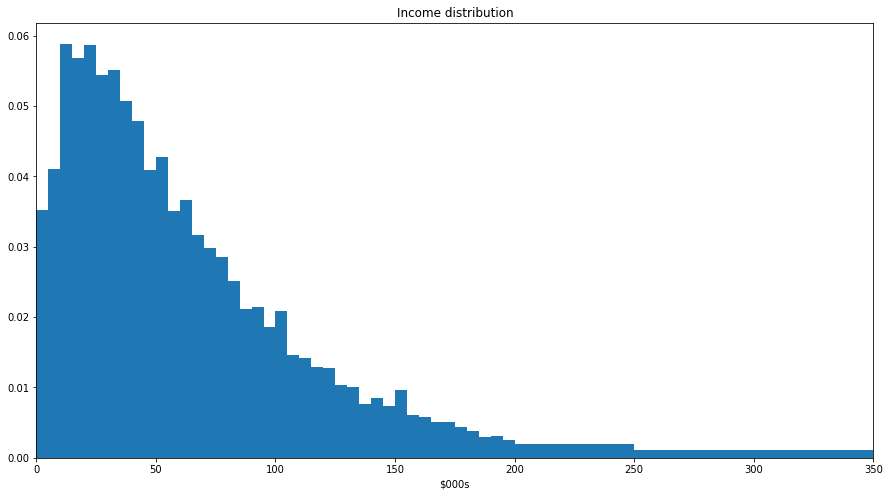

In [4]:
n = len(incomes_percent)

plt.figure(figsize=(15, 8))
plt.bar(incomes_percent.index, height=incomes_percent, width=5, align='edge')
plt.title('Income distribution')
plt.xlabel('$000s')
plt.xlim(0, 350)
plt.show()

Part b)

In [5]:
def log_norm(x, μ, σ):
    return 1 / (x * σ * np.sqrt(2 * np.pi)) * np.exp(-(np.log(x) - μ)**2 / (2 * σ**2))

In [6]:
from scipy.integrate import quad

def GMM(params, X, bins, f, W=None):
        
    if W is None:
        W = np.eye(len(X))
                
    # Get moments from model
    moments = np.zeros_like(X)
    for i in range(1, len(bins)):
        moments[i-1] = quad(f, bins[i-1], bins[i], args=(params[0], params[1]))[0]
    moments[-1] = quad(f, bins[-1], np.inf, args=(params[0], params[1]))[0] / 20
    moments[-2] = moments[-2] / 10
    
    # Find error between model and data
    e = (moments - X) / X
    
    # Return criterion value
    SSE = e.T @ W @ e
    
    return SSE

In [7]:
from scipy.optimize import minimize

μ_0 = np.log(np.sum(incomes * incomes.index))
σ_0 = 1
W = np.diag(incomes.values)
bins = incomes.index - 2.5

gmm_lognorm = minimize(GMM, [μ_0, σ_0], args=(incomes.values, bins, log_norm, W))
μ_hat, σ_hat = gmm_lognorm.x
print(f'μ = {μ_hat:.3f}')
print(f'σ = {σ_hat:.3f}')
print(f'GMM value = {gmm_lognorm.fun:.5f}')

μ = 3.798
σ = 0.878
GMM value = 0.13299


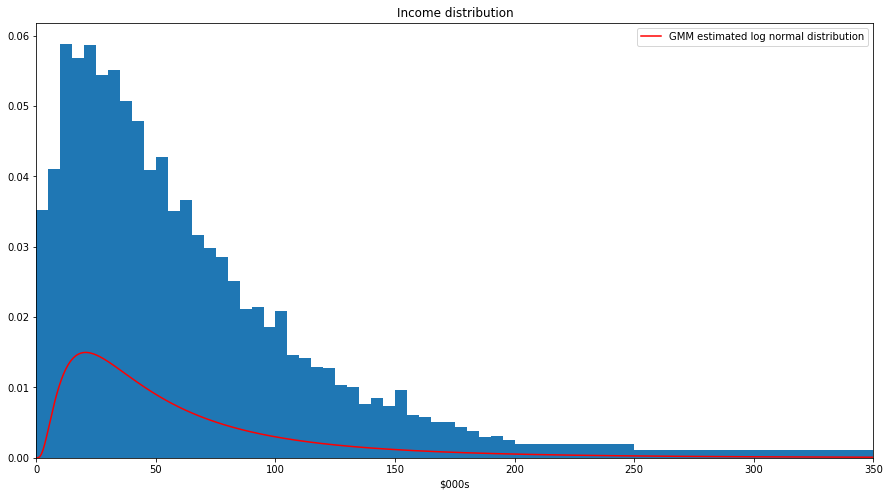

In [8]:
xgrid = np.linspace(1e-3, 350, 500)

plt.figure(figsize=(15, 8))
plt.bar(incomes_percent.index, height=incomes_percent, width=5, align='edge')
plt.plot(xgrid, log_norm(xgrid, μ_hat, σ_hat), color='red', label='GMM estimated log normal distribution')
plt.title('Income distribution')
plt.xlabel('$000s')
plt.xlim(0, 350)
plt.legend()
plt.show()

Part c)

In [9]:
from scipy.special import gamma

g = lambda x, α, β: (β**(-α) * x**(α - 1) * np.exp(-x / β)) / gamma(α)

In [10]:
α_0 = 3
β_0 = 50

gmm_gamma = minimize(GMM, [α_0, β_0], args=(incomes.values, bins, g, W))
α_hat, β_hat = gmm_gamma.x
print(f'α = {α_hat:.3f}')
print(f'β = {β_hat:.3f}')
print(f'GMM value = {gmm_gamma.fun:.5f}')

α = 1.551
β = 37.543
GMM value = 0.06697


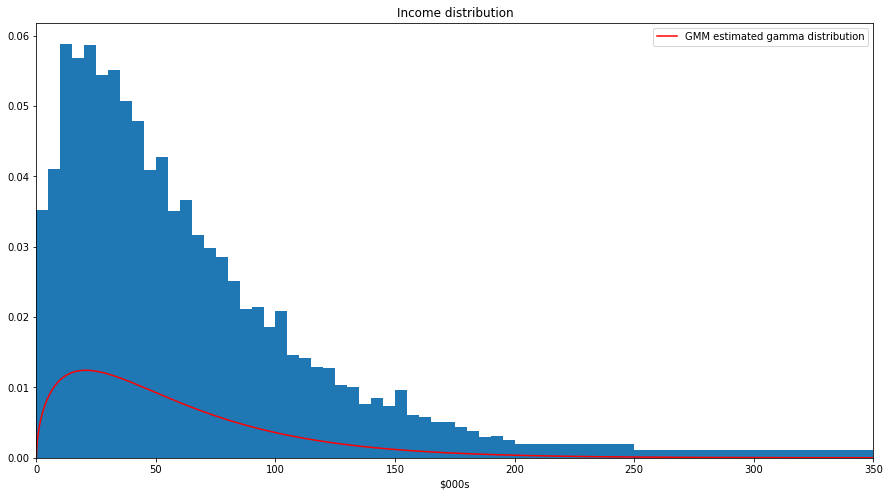

In [11]:
xgrid = np.linspace(1e-3, 350, 1000)

plt.figure(figsize=(15, 8))
plt.bar(incomes_percent.index, height=incomes_percent, width=5, align='edge')
plt.plot(xgrid, g(xgrid, α_hat, β_hat), color='red', label='GMM estimated gamma distribution')
plt.title('Income distribution')
plt.xlabel('$000s')
plt.xlim(0, 350)
plt.legend()
plt.show()

Part d)

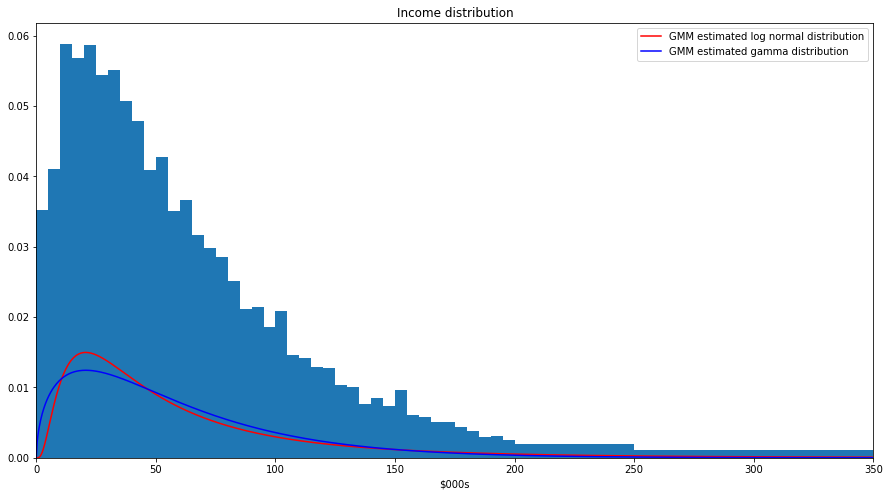

In [12]:
plt.figure(figsize=(15, 8))
plt.bar(incomes_percent.index, height=incomes_percent, width=5, align='edge')
plt.plot(xgrid, log_norm(xgrid, μ_hat, σ_hat), color='red', label='GMM estimated log normal distribution')
plt.plot(xgrid, g(xgrid, α_hat, β_hat), color='blue', label='GMM estimated gamma distribution')
plt.title('Income distribution')
plt.xlabel('$000s')
plt.xlim(0, 350)
plt.legend()
plt.show()

We can tell which distribution fits the data better by looking at their function values.

In [13]:
if gmm_gamma.fun - gmm_lognorm.fun > 0:
    print('Log normal distribution fits the data better')
else:
    print('Gamma distribution fits the data better')

Gamma distribution fits the data better


Part e)

In [14]:
def GMM_twostep(α_0, β_0, X, bins, f):
    
    N = len(X)
    gmm_gamma = minimize(GMM, [α_0, β_0], args=(X, bins, f))
    α_hat, β_hat = gmm_gamma.x
    
    moments = np.zeros_like(X)
    for i in range(1, len(bins)):
        moments[i-1] = quad(g, bins[i-1], bins[i], args=(α_hat, β_hat))[0]
    moments[-1] = quad(g, bins[-1], np.inf, args=(α_hat, β_hat))[0] / 20
    moments[-2] = moments[-2] / 10  
    
    # Find error between model and data
    e = (moments - X) / X
    
    Ω = np.outer(e, e.T) / N
    W_twostep = np.linalg.pinv(Ω)
            
    return minimize(GMM, [α_hat, β_hat], args=(X, bins, g, W_twostep))

In [15]:
gmm_twostep = GMM_twostep(α_hat, β_hat, incomes.values, bins, g)
α_hat, β_hat = gmm_twostep.x
print(f'α = {α_hat:.3f}')
print(f'β = {β_hat:.3f}')
print(f'GMM value = {gmm_twostep.fun:.5f}')

α = 1.779
β = 31.390
GMM value = 42.00000


## Exercise 4

Part a)

In [16]:
macro = pd.read_csv('MacroSeries.txt', header=None,
                    names=['c', 'k', 'w', 'r', 'y'])

In [17]:
def bm_gmm(params, w, k, c, W=None):
    
    α, μ, ρ, β = params  # Unpack parameters
    
    z = np.log(w / ((1 - α) * k**α))
    
    m = np.zeros(4)
    m[0] = np.mean(z[1:] - ρ * z[:-1] - (1 - ρ) * μ)
    m[1] = np.mean((z[1:] - ρ * z[:-1] - (1 - ρ) * μ) * z[:-1])
    m[2] = np.mean(β * α * np.exp(z[1:]) * k[1:]**(α - 1) * c[:-1]/c[1:] - 1)
    m[3] = np.mean((β * α * np.exp(z[1:]) * k[1:]**(α - 1) * (c[:-1]/c[1:]) - 1) * w[:-1])
    
    W = np.eye(4)
    
    return m.T @ W @ m

In [18]:
w = macro.w.values
k = macro.k.values
c = macro.c.values

macro_gmm = minimize(bm_gmm, np.ones(4), args=(w, k, c), method='L-BFGS-B', 
                     bounds=((1e-3, 0.99), (1e-3, None), (-0.99999, 0.99999), (1e-3, 0.99)))

α_hat, μ_hat, ρ_hat, β_hat = macro_gmm.x
print(f'α = {α_hat:.3f}')
print(f'μ = {μ_hat:.3f}')
print(f'ρ = {ρ_hat:.3f}')
print(f'β = {β_hat:.3f}')
print(f'Function value = {macro_gmm.fun:.3f}')

α = 0.510
μ = 1.000
ρ = 1.000
β = 0.688
Function value = 0.010
